# Mu2e Tracker Calibration

In the real world, each of the over 23,000 straws on the Mu2e tracker will have some variance when it comes to the energy deposition values measured by the backend electronics. Our initial goal then is to consider the case when each of the 36 panels are varied by some amount. We do this by finding some quantity that is theoretically invariant across all straws, and use this value in a ratio that scales the energy deposition values of each plane by an amount such that the new distribution obeys this value. In doing so, the planes will have been calibrated to account for any variance in electronic response.

Let us first important the necessary Python libraries.

In [3]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

Enter the path to the desired ROOT file containing simulated and Monte Carlo truth values.

In [4]:
files = ["/home/online1/rbonventre/energycalibration/trkana.planes.0.root"]

Our first goal is to calculate the energy deposited per unit distance traveled by an electron in a given straw. To do this, we naturally need the following parameters: rdoca (distance of closest approach from the fit reference), state (state of the hit in the last fit iteration), wdot (cosine of the angle between the wire and the local track direction), plane (plane of the hit), and edep (reconstructed estimate of the energy deposited by the particle in MeV using the ADC waveform).

In [5]:
data_fields = ["rdoca", "state", "wdot", "plane", "edep"]

We create two dictionaries to store the simulation and Monte Carlo truth values and append information to them using the uproot iterate process.

In [6]:
a = {field: [] for field in data_fields}
amc = {"edep": []}

for batch in uproot.iterate(files, filter_name="/kl|kltsh|kltshmc/i"):
    cutStatus = ak.sum(batch["kl.status"], axis=1) == 1
    for field in data_fields:
        a[field].append(ak.flatten(ak.flatten(batch["kltsh"][field][cutStatus])).to_numpy())
    amc["edep"].append(ak.flatten(ak.flatten(batch["kltshmc"]["edep"][ak.local_index(batch["kltshmc"]["edep"]) < ak.num(batch["kltsh"]["edep"],axis=2)][cutStatus])).to_numpy())
    break

for field in a:
    a[field] = np.concatenate(a[field])
amc["edep"] = np.concatenate(amc["edep"])

Via some simple geometry, we can calculate the pathlength for each track and store them in an array. Note that we perform a cut to ensure we only consider tracks with an accurate radial position.

In [7]:
pathLength = []
hitCut = (np.abs(a["state"]) == 1) & (np.abs(a["rdoca"]) < 2.5)
pathLength = np.abs((np.sqrt((6.25 - (a["rdoca"][hitCut])**2) / 4)) / (np.sin(np.arccos((a["wdot"][hitCut])))))

Our invariant value between planes will be the average of the average energy deposited per unit length of each plane. This makes sense, because across each plane, the ratio of energy deposited to distance traveled should be the same.

As such, we must calculate the average energy deposited per unit length of each plane, then calculate the invariant value, and ultimately scale the energy deposition values by the ratio between a plane's de/dx value and the invariant value.

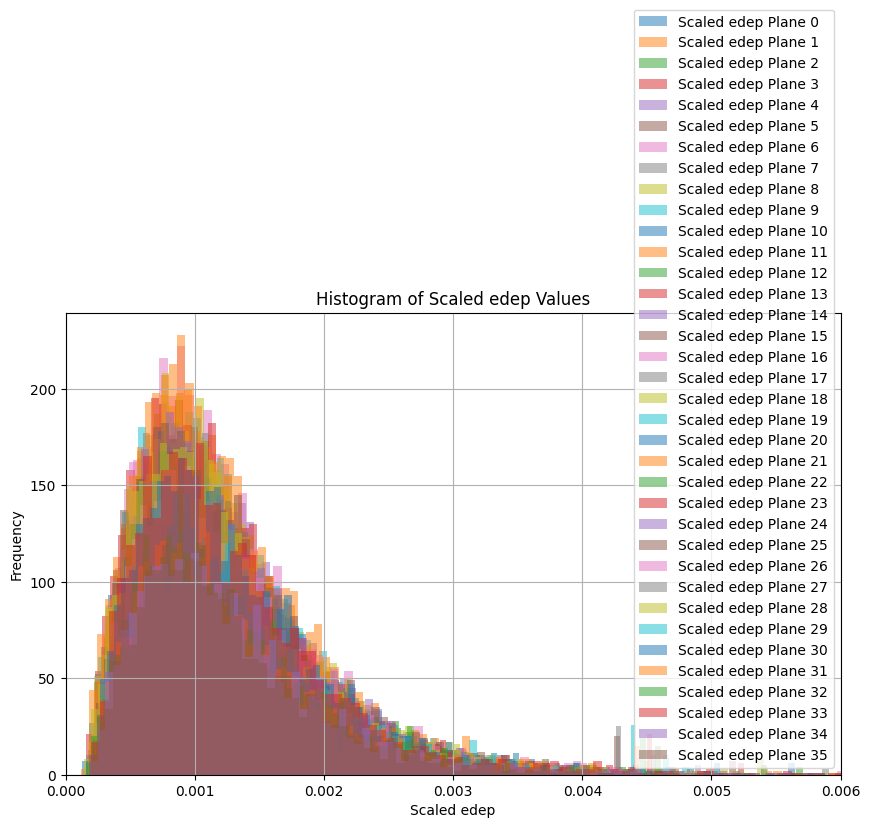

0.8867263


In [38]:
average_dedx_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    pathCut = pathLength >= 1.3
    de = a["edep"][hitCut]
    path = pathLength
    dedx = de[planeCut & pathCut]/path[planeCut & pathCut]
    average_dedx = np.mean(dedx)
    average_dedx_per_plane.append(average_dedx)

target_mean = np.mean(average_dedx_per_plane)
normalized_average_dedx_per_plane = [average_dedx / target_mean for average_dedx in average_dedx_per_plane]

scaled_edep_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    de = a["edep"][hitCut]
    scaled_de = de[planeCut] / normalized_average_dedx_per_plane[plane]
    scaled_edep_per_plane.append(scaled_de)

plt.figure(figsize=(10, 6))
for plane, scaled_de in enumerate(scaled_edep_per_plane):
    plt.hist(scaled_de, bins=100, alpha=0.5, label=f'Scaled edep Plane {plane}')
plt.xlabel('Scaled edep')
plt.ylabel('Frequency')
plt.title('Histogram of Scaled edep Values')
plt.legend()
plt.grid(True)
plt.xlim(0.00, 0.006)
plt.show()

print(normalized_average_dedx_per_plane[0])

To verify that the scaling works, we can plot the ratio between the unscaled edep and mcedep values, and compare it to the plot of the ratio between the scaled edep and mcedep values.

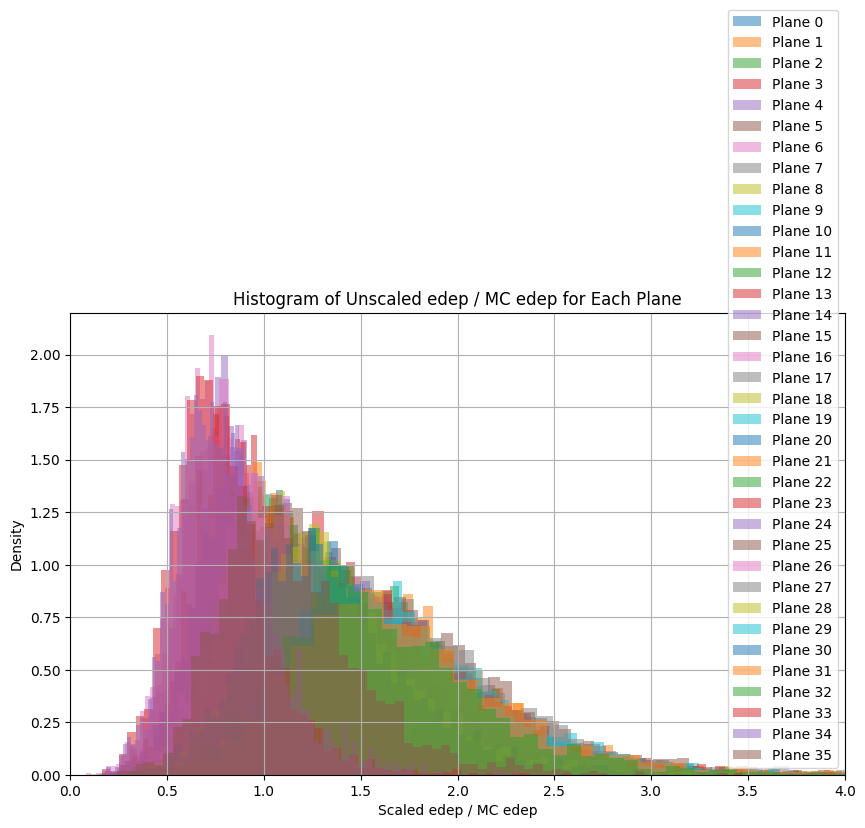

In [28]:
ratio_unscaled_edep_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    demc = amc["edep"][hitCut][planeCut]
    unscaled_de = a["edep"][hitCut][planeCut]
    ratio = unscaled_de / demc
    ratio_unscaled_edep_per_plane.append(ratio)

plt.figure(figsize=(10, 6))
for plane, ratio in enumerate(ratio_unscaled_edep_per_plane):
    plt.hist(ratio, bins=100, alpha=0.5, label=f'Plane {plane}', density=True)
plt.xlabel('Scaled edep / MC edep')
plt.ylabel('Density')
plt.title('Histogram of Unscaled edep / MC edep for Each Plane')
plt.legend()
plt.xlim(0,4)
plt.grid(True)

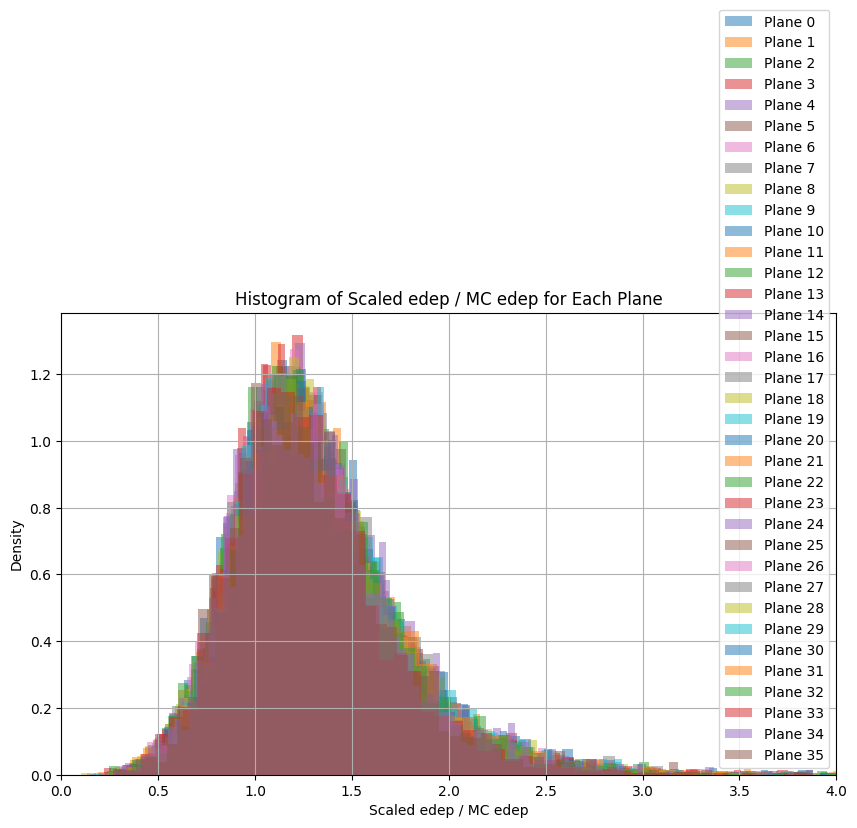

In [27]:
ratio_scaled_edep_per_plane = []
for plane in range(36):
    planeCut = a["plane"][hitCut] == plane
    demc = amc["edep"][hitCut][planeCut]
    scaled_de = scaled_edep_per_plane[plane]
    ratio = scaled_de / demc
    ratio_scaled_edep_per_plane.append(ratio)

plt.figure(figsize=(10, 6))
for plane, ratio in enumerate(ratio_scaled_edep_per_plane):
    plt.hist(ratio, bins=100, alpha=0.5, label=f'Plane {plane}', density=True)
plt.xlabel('Scaled edep / MC edep')
plt.ylabel('Density')
plt.title('Histogram of Scaled edep / MC edep for Each Plane')
plt.legend()
plt.grid(True)
plt.xlim(0,4)
plt.show()

We can clearly see that the distribution is more narrow and centered around 1 as it should.

The next natural step is to make a scatter plot of scaled edep vs mcedep for a particular plane and fit it to a line. We then expect a slope of 1, and can consider the range of scaled edep values that are properly scaled using this calibration method.

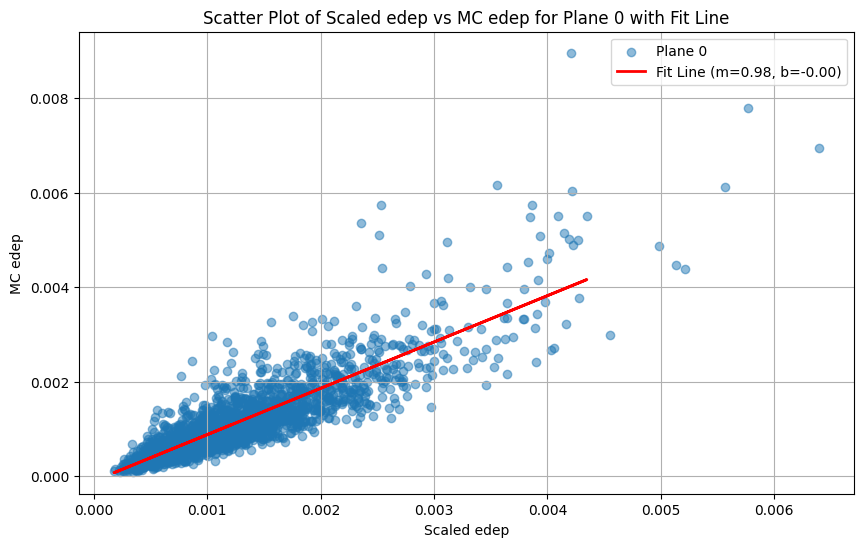

Minimum value in filtered_scaled_de: 0.00017650311929173768
Maximum value in filtered_scaled_de: 0.004346899222582579


In [37]:
plt.figure(figsize=(10, 6))
plane = 0
scaled_de = scaled_edep_per_plane[plane]
demc = amc["edep"][hitCut][a["plane"][hitCut] == plane]

min_scaled_de = 0
max_scaled_de = 0.0045
filtered_scaled_de = [de for de in scaled_de if min_scaled_de <= de <= max_scaled_de]
filtered_demc = [demc[i] for i, de in enumerate(scaled_de) if min_scaled_de <= de <= max_scaled_de]

m, b = np.polyfit(filtered_scaled_de, filtered_demc, 1)
plt.scatter(scaled_de, demc, alpha=0.5, label=f'Plane {plane}')
plt.plot(filtered_scaled_de, m*np.array(filtered_scaled_de) + b, color='red', linewidth=2, label=f'Fit Line (m={m:.2f}, b={b:.2f})')
plt.xlabel('Scaled edep')
plt.ylabel('MC edep')
plt.title('Scatter Plot of Scaled edep vs MC edep for Plane 0 with Fit Line')
plt.legend()
plt.grid(True)
plt.show()
print(f"Minimum value in filtered_scaled_de: {min(filtered_scaled_de)}")
print(f"Maximum value in filtered_scaled_de: {max(filtered_scaled_de)}")


In plane 0 for example, the range of well-fitted scaled edep values is 0.000 to 0.0045. We can convert this back to the original edep values to see the range of edep values that this calibration method works best on.

In [36]:
original_de_values = [de * normalized_average_dedx_per_plane[plane] for de in filtered_scaled_de]
print(f"Minimum value in original_de_values: {min(original_de_values)}")
print(f"Maximum value in original_de_values: {max(original_de_values)}")

Minimum value in original_de_values: 0.00015650996647309512
Maximum value in original_de_values: 0.00385450990870595


It is often useful to find the root mean square RMS of a distribution, as we will do now.